<a href="https://colab.research.google.com/github/DingLi23/s2search/blob/pipelining/pipelining/pdp-exp1/pdp-exp1_cslg-rand-200_plotting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment Description

Produce PDP for a randomly picked data from cslg.

> This notebook is for experiment \<pdp-exp1\> and data sample \<cslg-rand-200\>.

### Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/pdp-exp1/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


### Loading data

In [2]:
sys.path.insert(1, '../../')
import numpy as np, sys, os

sample_name = 'cslg-rand-200'

f_list = ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']

pdp_data_map = {}
weird_score = {}

for f in f_list:
    feature_pdp_data = np.load(os.path.join('.', 'scores', f'{sample_name}_pdp_{f}.npz'))['arr_0']
    # print(len(feature_pdp_data))
    pdp_data_map[f] = feature_pdp_data
    for score in feature_pdp_data:
        if score > 20:
            weird_score[f] = ''


### PDP

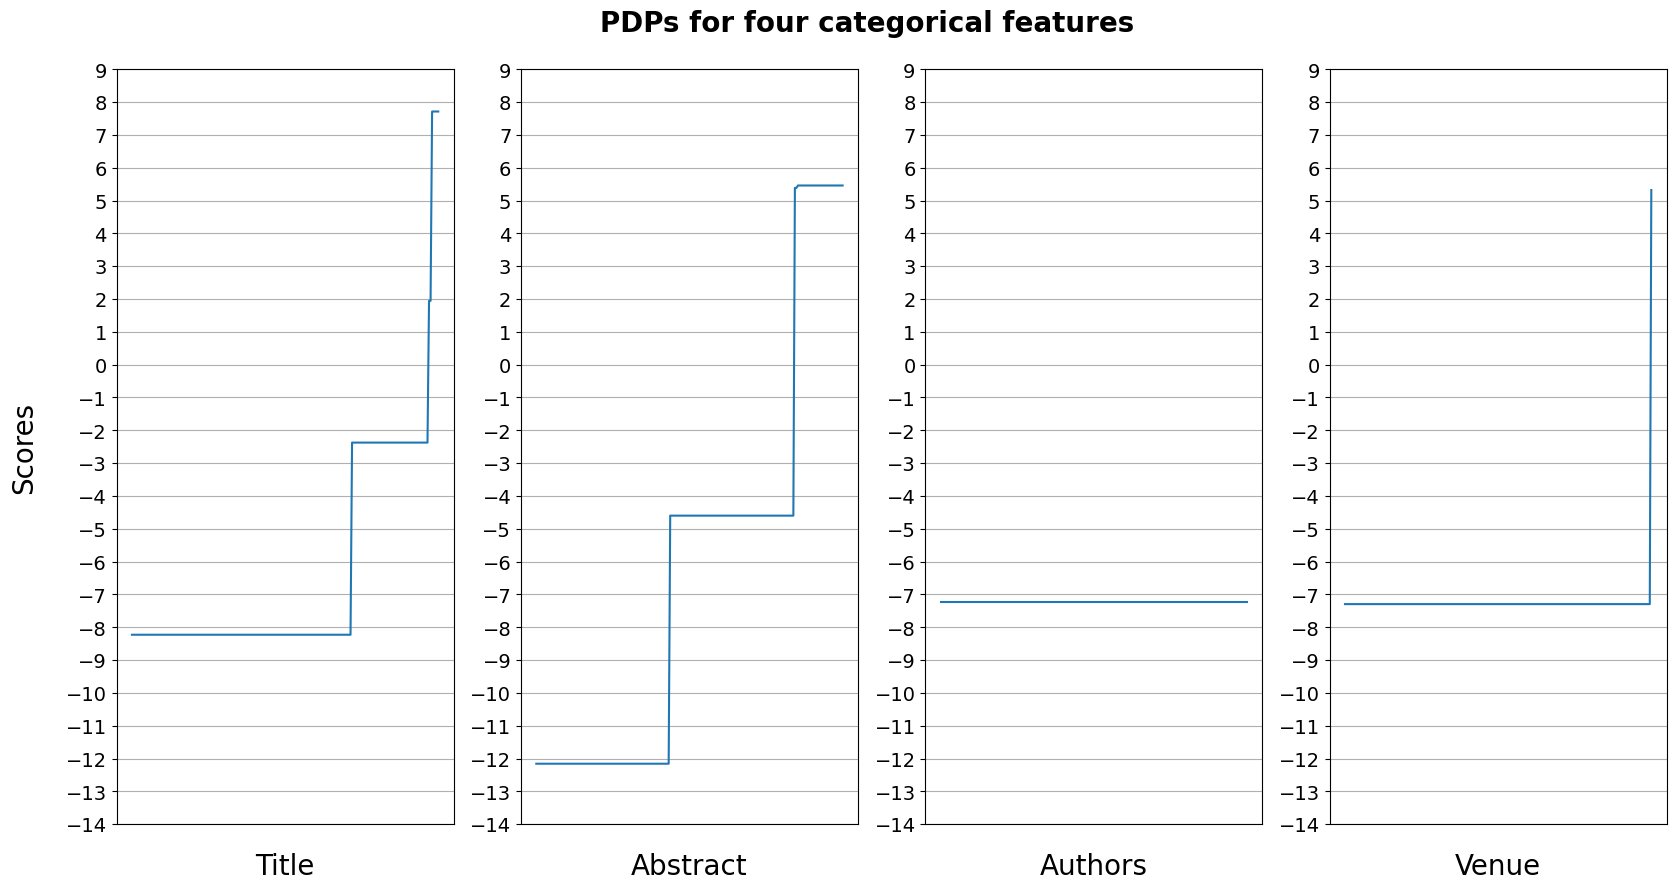

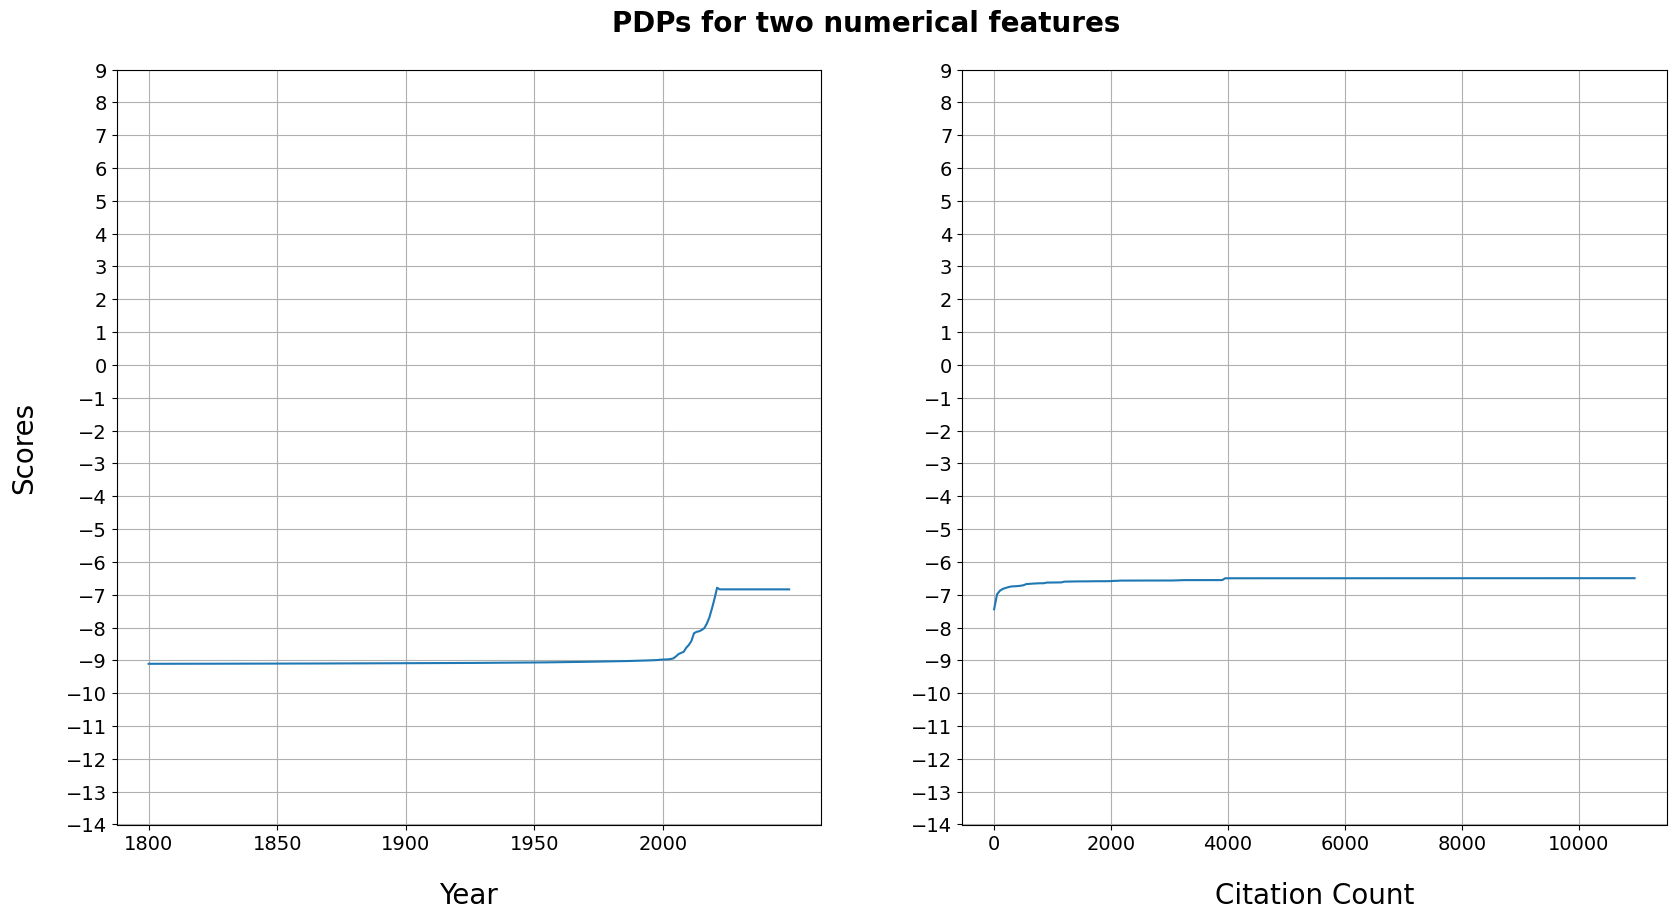

In [3]:
import matplotlib.pyplot as plt

categorical_plot_conf = {
    'title': {
        'xlabel': 'Title',
        'ylabel': 'Scores',
        'x': list(range(len(pdp_data_map['title']))),
        'y': np.sort(pdp_data_map['title']),
        'yticks': list(range(-14, 10, 1)),
    },
    'abstract': {
        'xlabel': 'Abstract',
        'x': list(range(len(pdp_data_map['abstract']))),
        'y': np.sort(pdp_data_map['abstract']),
        'yticks': list(range(-14, 10, 1)),
    },    
    'authors': {
        'xlabel': 'Authors',
        'x': list(range(len(pdp_data_map['authors']))),
        'y': np.sort(pdp_data_map['authors']),
        'yticks': list(range(-14, 10, 1)),
    },
    'venue': {
        'xlabel': 'Venue',
        'x': list(range(len(pdp_data_map['venue']))),
        'y': np.sort(pdp_data_map['venue']),
        'yticks': list(range(-14, 10, 1)),
    },
}

numerical_plot_conf = {
    'year': {
        'xlabel': 'Year',
        'ylabel': 'Scores',
        'x': list(range(1800, 2050)),
        'y': pdp_data_map['year'],
        'xticks': list(range(1800, 2050, 50)),
        'yticks': list(range(-14, 10, 1)),
    },
    'n_citations': {
        'xlabel': 'Citation Count',
        'x': list(range(0, 11000, 50)),
        'y': pdp_data_map['n_citations'],
        'xticks': list(range(0, 11000, 2000)),
        'yticks': list(range(-14, 10, 1)),
    }
}

def pdp_plot(confs):
    idx = 1
    for key in confs.keys():
        conf = confs[key]
        plt.subplot(1, len(confs), idx)
        plt.plot(conf['x'], conf['y'])

        plt.xlabel(conf['xlabel'], fontsize=20, labelpad=20)
        if (conf.get('ylabel') != None):
            plt.ylabel(conf.get('ylabel'), fontsize=20, labelpad=20)

        if conf.get('xticks') != None:
            plt.xticks(conf.get('xticks'), fontsize=14)
        else:
            plt.xticks([], fontsize=14)
            
        if weird_score.get(key) == None:
            plt.yticks(list(range(-14, 10, 1)), fontsize=14)
        else:
            plt.yticks(fontsize=14)
            
        plt.grid()
        idx += 1

plt.figure(figsize=(20, 10), dpi=100)
plt.suptitle("PDPs for four categorical features", y=0.94, fontsize=20, fontweight='bold')
pdp_plot(categorical_plot_conf)
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-categorical.png'), facecolor='white', transparent=False, bbox_inches='tight')

# second fig
plt.figure(figsize=(20, 10), dpi=100)
plt.suptitle("PDPs for two numerical features", y=0.94, fontsize=20, fontweight='bold')
pdp_plot(numerical_plot_conf)
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-numerical.png'), facecolor='white', transparent=False, bbox_inches='tight')

plt.show()
